# Setting

In [34]:
args = {
        # model setting
        'embedding_dim': 64,
        'gamma': 1e-4,
        'lambda_': 0.8,
        
        # train setting
        'batch_size': 1024,
        'n_epochs': 5,
        
        # data, model save path
        'data_dir': '../data/',
        'model_save_dir': 'save'
        }

In [1]:
import torch
device = torch.device('cuda:0')
torch.cuda.is_available()

True

# Dataset

In [37]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
import pickle
import torch

class UltraGCNDataset(Dataset):
    def __init__(self, data_dir, training: bool=True):
        if not os.path.exists(os.path.join(data_dir, "gcn_train.csv")):
            self.train = pd.read_csv(os.path.join(data_dir, "train_data.csv"))
            self.test = pd.read_csv(os.path.join(data_dir, "test_data.csv"))
            gcn_preprocess(self.train, self.test)
            
        if training: self.data = pd.read_csv(os.path.join(data_dir, "gcn_train.csv"))
        else: self.data = pd.read_csv(os.path.join(data_dir, "gcn_test.csv"))
        
        self.X = self.data.drop('answerCode', axis=1)
        self.y = self.data.answerCode

    def __getitem__(self, index):
        return self.X.loc[index].values, self.y.loc[index]

    def __len__(self):
        return len(self.data)


class UltraGCNDataLoader(DataLoader):
    def __init__(self, args, num_workers=4, random_seed=42):

        self.data_dir = args['data_dir']
        self.random_seed = random_seed
        self.dataset = UltraGCNDataset(args['data_dir'])

        super().__init__(self.dataset, batch_size=args['batch_size'], shuffle=False, num_workers=4)


# preprocess
def gcn_preprocess(train, test):
    data = pd.concat([train, test]).drop_duplicates(subset = ["userID", "assessmentItemID"], keep = "last")
    data = indexing(data)

    train_data = data[data.answerCode >= 0]
    test_data = data[data.answerCode == -1]

    train_data.to_csv("gcn_train.csv", index=False)
    test_data.to_csv("gcn_test.csv", index=False)

    save_constraint_matrix(data)

def indexing(data):
    uid, iid = sorted(list(set(data.userID))), sorted(list(set(data.assessmentItemID)))

    user2idx = {v:i for i,v in enumerate(uid)}
    item2idx = {v:i for i,v in enumerate(iid)}

    data.userID = data.userID.map(user2idx)
    data.assessmentItemID = data.assessmentItemID.map(item2idx)

    return data[['userID', 'assessmentItemID', 'answerCode']]


def save_constraint_matrix(data):
    user = data.groupby('userID').agg({'assessmentItemID':'count'}).sort_values('userID').assessmentItemID.to_list()
    item = data.groupby('assessmentItemID').agg({'userID':'count'}).sort_values('assessmentItemID').userID.to_list()

    constraint_matrix = {"d_user": torch.Tensor(user), "d_item": torch.Tensor(item)}
    with open('constraint_matrix.pickle', 'wb') as f: pickle.dump(constraint_matrix, f)

# Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torch

class UltraGCN(nn.Module):
    def __init__(self, args):
        super(UltraGCN, self).__init__()

        self.user_num = 7442
        self.item_num = 9454
        self.embedding_dim = args['embedding_dim']

        self.gamma = args['gamma']
        self.lambda_ = args['lambda_']

        self.user_embeds = nn.Embedding(self.user_num, self.embedding_dim)
        self.item_embeds = nn.Embedding(self.item_num, self.embedding_dim)

        with open('constraint_matrix.pickle', 'rb') as f: self.constraint_mat = pickle.load(f)
        self.initial_weights()

    def initial_weights(self):
        nn.init.xavier_normal_(self.user_embeds.weight)
        nn.init.xavier_normal_(self.item_embeds.weight)

    def forward(self, data):
        users = data[:, 0]
        items = data[:, 1]

        user_embeds = self.user_embeds(users)
        item_embeds = self.item_embeds(items)
        return (user_embeds * item_embeds).sum(dim=-1).sigmoid()

def get_betas(model, users, items):
    d_user = model.constraint_mat['d_user'].to(device)
    d_item = model.constraint_mat['d_item'].to(device)

    weights = 1 + model.lambda_ * (1/d_user[users]) * torch.sqrt((d_user[users]+1)/(d_item[items]+1))
    return weights


def get_BCE(beta_weight, output, target):
    loss = F.binary_cross_entropy(output, target.float(), weight=beta_weight, reduction='none')
    return loss.sum()


def norm_loss(model):
    loss = 0.0
    for parameter in model.parameters():
        loss += torch.sum(parameter ** 2)
    return loss / 2


def UltraGCN_loss(model, output, data, target):
    users = data[:, 0]
    items = data[:, 1]
    beta_weight = get_betas(model, users, items)

    loss = get_BCE(beta_weight, output, target)
    loss += model.gamma * norm_loss(model)
    return loss

# Train

In [32]:
import os
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
from torch.utils.data import RandomSampler, DataLoader

dataset = UltraGCNDataset(args['data_dir'])
dataloader = UltraGCNDataLoader(args)

model = UltraGCN(args).to(device)

random_sampler = RandomSampler(dataset, num_samples=args['batch_size'], replacement=True)
valid_dataloader = DataLoader(dataset, batch_size=args['batch_size'], sampler=random_sampler, num_workers=6)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

best_auc = 0
for e in range(args['n_epoches']):
    model.train()
    for idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        output = model(data).to(device)
        loss = UltraGCN_loss(model, output, data, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 50 == 0: print(f'{(idx) * 1024} / {len(dataset)}: loss: {(loss / 1024):.4f},')
    
    model.eval()
    with torch.no_grad():
        for idx, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            output, target = output.cpu(), target.cpu()
            acc = accuracy_score(y_true=target, y_pred=output > 0.5)
            auc = roc_auc_score(y_true=target, y_score=output)
        print(f"VALID AUC: {auc:.4f}, ACC: {acc:.4f}")

    if auc > best_auc:
        best_auc, best_epoch = auc, e
        torch.save(obj= {"model": model.state_dict(), "epoch": e + 1},
                    f=os.path.join(args['model_save_dir'], "best_model.pt"))

0 / 2475962: loss: 0.6947,
51200 / 2475962: loss: 0.6944,
102400 / 2475962: loss: 0.6942,
153600 / 2475962: loss: 0.6943,
204800 / 2475962: loss: 0.6943,
256000 / 2475962: loss: 0.6946,
307200 / 2475962: loss: 0.6944,
358400 / 2475962: loss: 0.6945,
409600 / 2475962: loss: 0.6940,
460800 / 2475962: loss: 0.6950,
512000 / 2475962: loss: 0.6944,
563200 / 2475962: loss: 0.6938,
614400 / 2475962: loss: 0.6943,
665600 / 2475962: loss: 0.6944,
716800 / 2475962: loss: 0.6919,
768000 / 2475962: loss: 0.6941,
819200 / 2475962: loss: 0.6943,
870400 / 2475962: loss: 0.6944,
921600 / 2475962: loss: 0.6941,
972800 / 2475962: loss: 0.6929,
1024000 / 2475962: loss: 0.6934,
1075200 / 2475962: loss: 0.6935,
1126400 / 2475962: loss: 0.6949,
1177600 / 2475962: loss: 0.6931,
1228800 / 2475962: loss: 0.6932,
1280000 / 2475962: loss: 0.6949,
1331200 / 2475962: loss: 0.6947,
1382400 / 2475962: loss: 0.6947,
1433600 / 2475962: loss: 0.6942,
1484800 / 2475962: loss: 0.6938,
1536000 / 2475962: loss: 0.6944,
158

# Inference

In [66]:
model = UltraGCN(args)
model.load_state_dict(torch.load(os.path.join(args['model_save_dir'], "best_model.pt"))['model'])

test_dataset = UltraGCNDataset(args['data_dir'], training=False)
test_dataloader = DataLoader(test_dataset)
model.eval()

inference = []
with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
        pred = model(data).item()
        inference.append(pred)

submission = pd.read_csv(os.path.join(args['data_dir'], 'sample_submission.csv'))
submission['prediction'] = inference
submission.to_csv('UltraGCN_submission.csv', index=False)

# print(submission)

      id  prediction
0      0    0.468775
1      1    0.809308
2      2    0.258043
3      3    0.549906
4      4    0.353583
..   ...         ...
739  739    0.472559
740  740    0.602555
741  741    0.865178
742  742    0.319496
743  743    0.671359

[744 rows x 2 columns]


# EDA

In [71]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

u_imb = model.user_embeds.weight.detach().numpy()
i_imb = model.item_embeds.weight.detach().numpy()

tsne = TSNE(n_components=2)
u = tsne.fit_transform(u_imb)
i = tsne.fit_transform(i_imb)

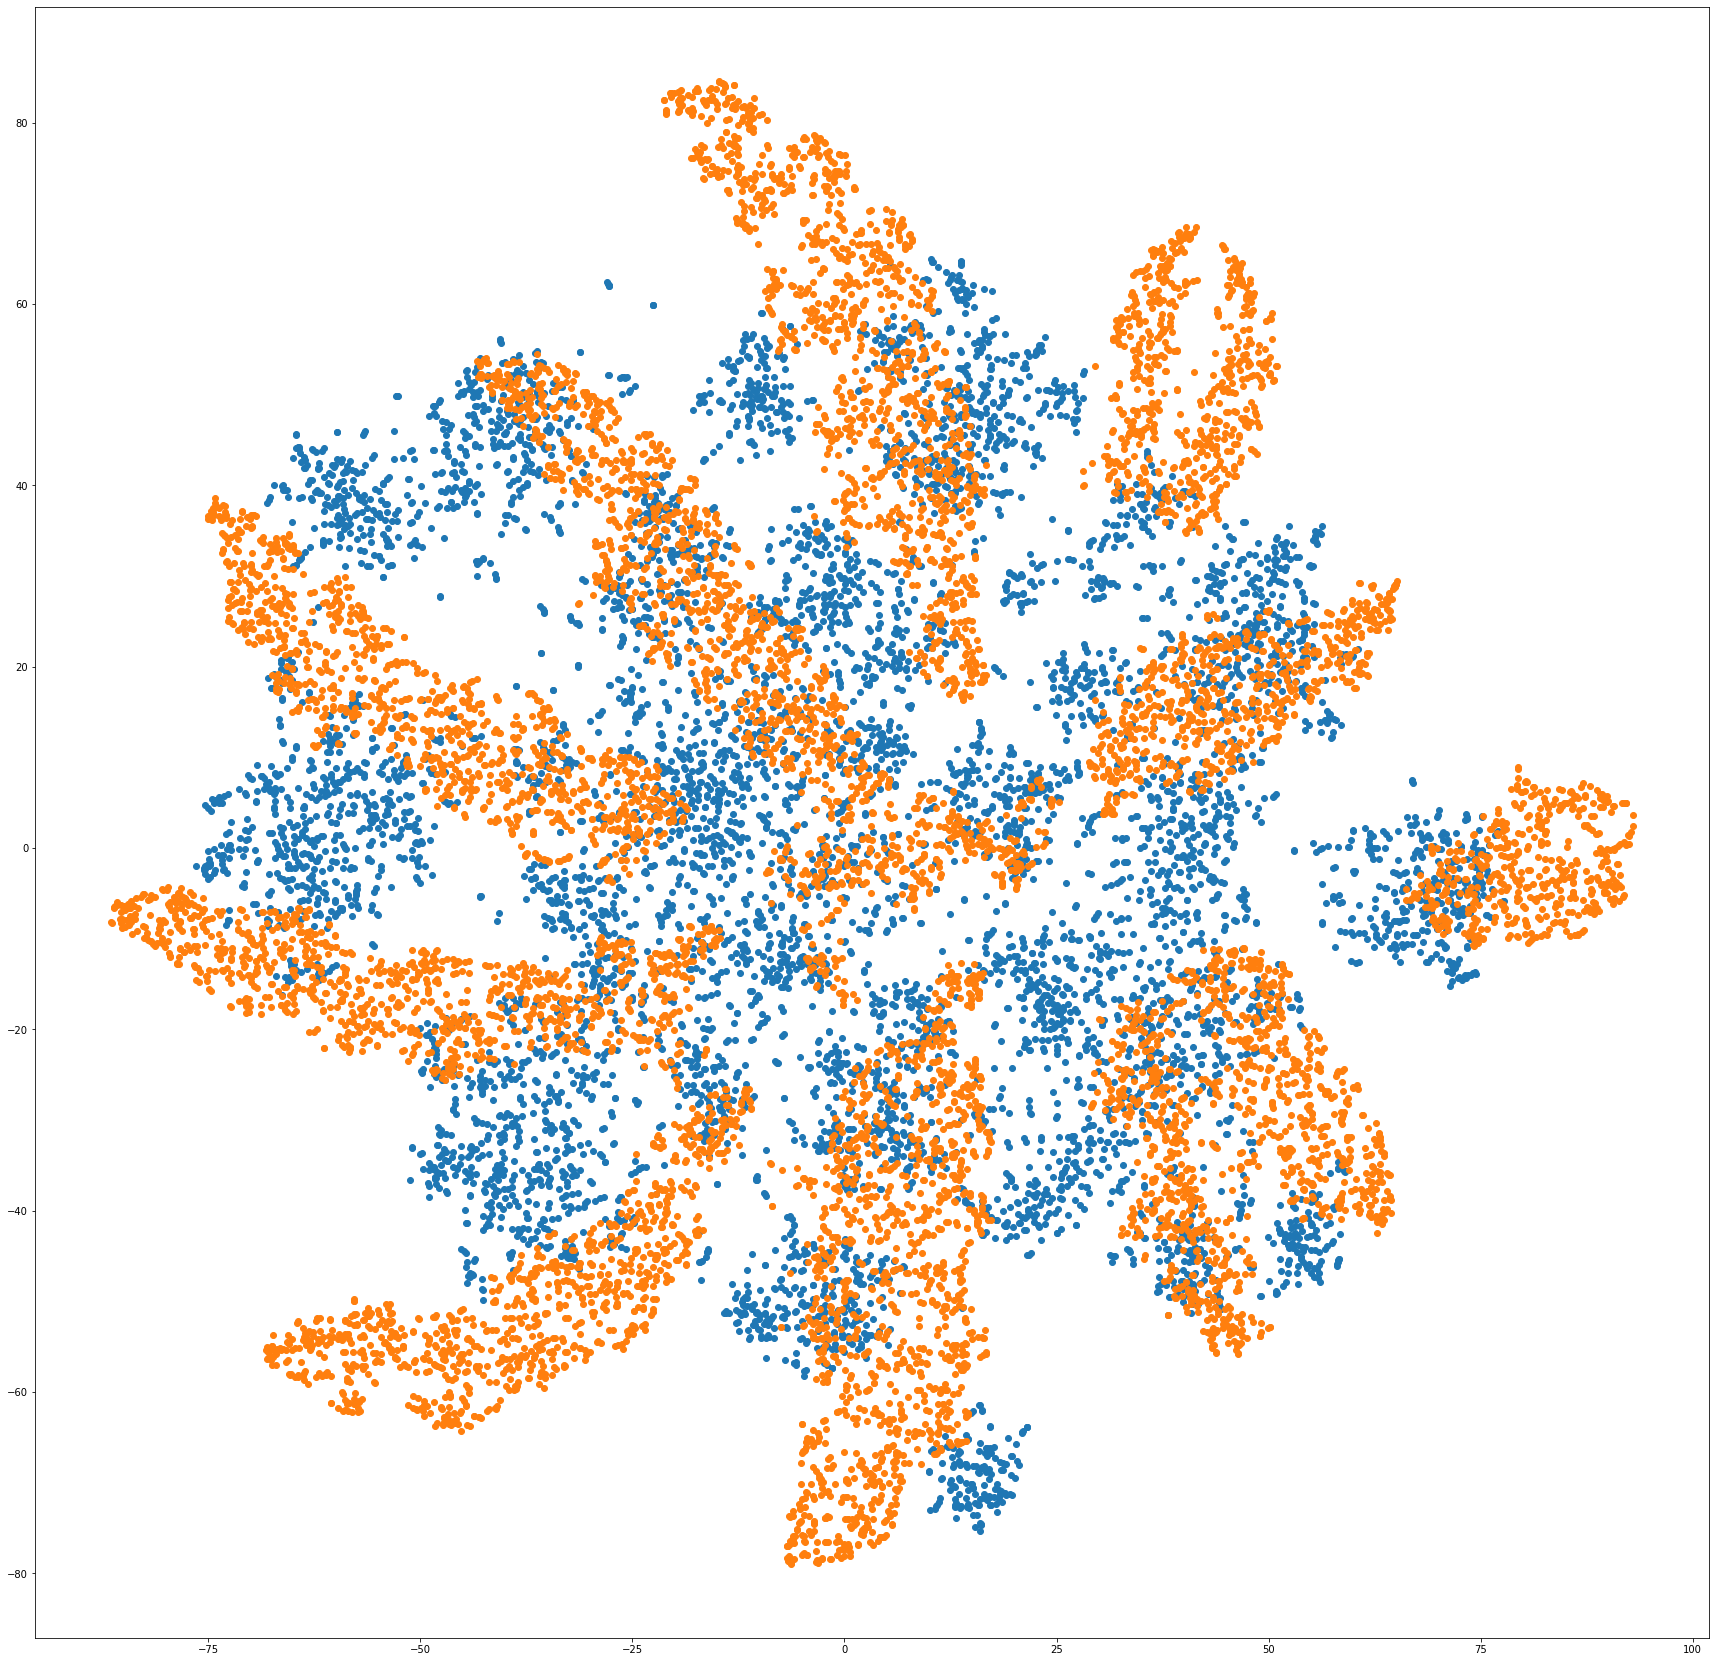

In [72]:
plt.figure(figsize=(30,30))
plt.scatter(u[:, 0], u[:, 1])
plt.scatter(i[:, 0], i[:, 1])
plt.show()